3D-VGG-16

In [1]:
import numpy as np
import pandas as pd
import pydicom as dicom
import os
import matplotlib.pyplot as plt
import cv2
import math
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam

In [ ]:
DATA_DIR = 'Data/'
LABELS_CSV = 'LungCT-Labels - Sheet1.csv'
IMG_SIZE_PX = 150
SLICE_COUNT = 20

In [ ]:
def build_vgg3d(input_shape=(SLICE_COUNT, IMG_SIZE_PX, IMG_SIZE_PX, 1), num_classes=2):
    inputs = Input(shape=input_shape)
    
    x = layers.Conv3D(64, kernel_size=3, padding='same', activation='relu')(inputs)
    x = layers.Conv3D(64, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPooling3D(pool_size=2, strides=2, padding='same')(x)
    
    x = layers.Conv3D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv3D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPooling3D(pool_size=2, strides=2, padding='same')(x)

    x = layers.Conv3D(256, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv3D(256, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv3D(256, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPooling3D(pool_size=2, strides=2, padding='same')(x)

    x = layers.Conv3D(512, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv3D(512, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv3D(512, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPooling3D(pool_size=2, strides=2, padding='same')(x)

    x = layers.Conv3D(512, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv3D(512, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv3D(512, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPooling3D(pool_size=2, strides=2, padding='same')(x)
    
    # Flatten and Dense Layers
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

In [ ]:
def load_data(data_dir, labels_df, img_size_px=IMG_SIZE_PX, hm_slices=SLICE_COUNT):
    image_full_data = []
    
    patients = os.listdir(data_dir)

    for patient in patients:
        label = labels_df.at[patient, 'Labels']
        path = os.path.join(data_dir, patient)
        slices = [dicom.read_file(os.path.join(path, s)) for s in os.listdir(path)]
        slices.sort(key=lambda x: int(x.ImagePositionPatient[2]))

        new_slices = []
        slices = [cv2.resize(np.array(each_slice.pixel_array), (img_size_px, img_size_px)) for each_slice in slices]
        
        chunk_sizes = math.ceil(len(slices) / hm_slices)
        for i in range(0, len(slices), chunk_sizes):
            slice_chunk = slices[i:i + chunk_sizes]
            if len(slice_chunk) > 0:
                new_slices.append(np.mean(slice_chunk, axis=0))

        if len(new_slices) < hm_slices:
            last_slice = new_slices[-1]
            while len(new_slices) < hm_slices:
                new_slices.append(last_slice)

        image_full_data.append([new_slices, np.array([1, 0]) if label == 1 else np.array([0, 1])])

    return image_full_data

In [ ]:
labels_df = pd.read_csv(LABELS_CSV, index_col=0)

image_full_data = load_data(DATA_DIR, labels_df)


In [ ]:
np.random.shuffle(image_full_data)
train_data = image_full_data[:int(len(image_full_data) * 0.8)]
validation_data = image_full_data[int(len(image_full_data) * 0.8):]

train_X = np.array([data[0] for data in train_data])
train_Y = np.array([data[1] for data in train_data])
valid_X = np.array([data[0] for data in validation_data])
valid_Y = np.array([data[1] for data in validation_data])


In [ ]:
train_X = train_X.reshape((-1, SLICE_COUNT, IMG_SIZE_PX, IMG_SIZE_PX, 1))
valid_X = valid_X.reshape((-1, SLICE_COUNT, IMG_SIZE_PX, IMG_SIZE_PX, 1))


In [ ]:
model = build_vgg3d(input_shape=(SLICE_COUNT, IMG_SIZE_PX, IMG_SIZE_PX, 1))


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20, 150, 150,   │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 20, 150, 150,   │         1,792 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 20, 150, 150,   │       110,656 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 10, 75, 75, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 10, 75, 75,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 10, 75, 75,     │       442,496 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 5, 38, 38, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 5, 38, 38, 256) │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 5, 38, 38, 256) │     1,769,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_6 (Conv3D)               │ (None, 5, 38, 38, 256) │     1,769,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 3, 19, 19, 256) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 3, 19, 19, 512) │     3,539,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_8 (Conv3D)               │ (None, 3, 19, 19, 512) │     7,078,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_9 (Conv3D)               │ (None, 3, 19, 19, 512) │     7,078,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 2, 10, 10, 512) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_10 (Conv3D)              │ (None, 2, 10, 10, 512) │     7,078,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_11 (Conv3D)              │ (None, 2, 10, 10, 512) │     7,078,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_12 (Conv3D)              │ (None, 2, 10, 10, 512) │     7,078,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 1, 5, 5, 512)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    52,432,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 113,354,562 (432.41 MB)

 Trainable params: 113,354,562 (432.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(train_X, train_Y, batch_size=5, epochs=10, validation_data=(valid_X, valid_Y))


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 504s 50s/step - accuracy: 0.6463 - loss: 9352.0596 - val_accuracy: 0.4615 - val_loss: 0.7793
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 425s 42s/step - accuracy: 0.6940 - loss: 0.7035 - val_accuracy: 0.4615 - val_loss: 30.2472
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 394s 39s/step - accuracy: 0.6216 - loss: 4.6287 - val_accuracy: 0.4615 - val_loss: 0.7193
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 407s 41s/step - accuracy: 0.5691 - loss: 0.6871 - val_accuracy: 0.4615 - val_loss: 7.5133
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 429s 43s/step - accuracy: 0.7004 - loss: 1.9471 - val_accuracy: 0.4615 - val_loss: 0.7377
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 429s 43s/step - accuracy: 0.6957 - loss: 0.6917 - val_accuracy: 0.4615 - val_loss: 0.8042
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 417s 41s/step - accuracy: 0.6642 - loss: 0.6352 - val_accuracy: 0.4615 - val_loss: 0.7996
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 398s 40s/step - accuracy: 0.6720 - loss: 0.6289 - val_accuracy

In [ ]:
model.save("vgg3d_model.h5")


In [ ]:
def plot_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

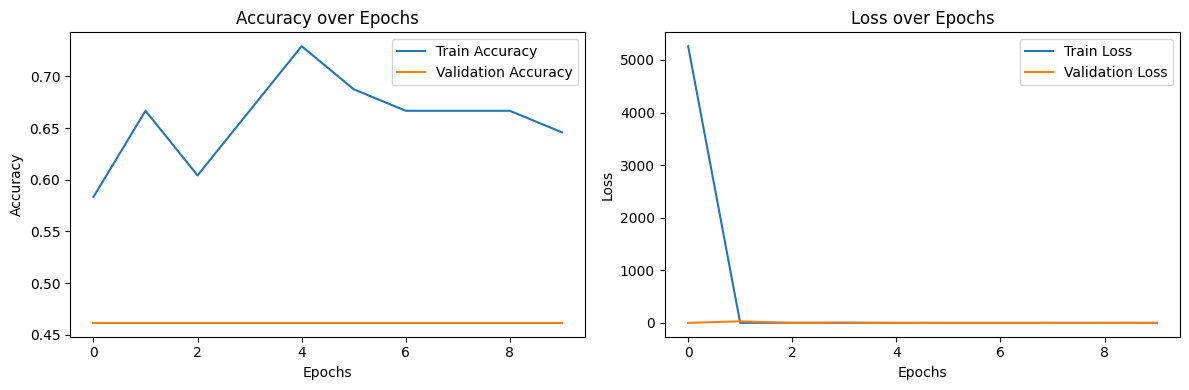

In [ ]:
plot_history(history)